# About log_data_to_sequence

This notebook creates minable sequences from log data given a predetermined translation of log actions to sequence actions.

In [1]:
%load_ext autoreload
%autoreload 1
%aimport utils_timeline_viz
%aimport utils_read_parsing
from utils_timeline_viz import *
from utils_read_parsing import *
%matplotlib inline
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = 25, 15
from matplotlib.backends.backend_pdf import PdfPages
import os
import numpy as np
import pandas as pd
import getpass
import datetime
import json
import matplotlib
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None);pd.set_option('display.max_rows', None);pd.set_option('precision', 2)
# FOLDER =  'C:\\Users\\'+getpass.getuser()+'\\Documents\\Personal Content\\Lab_skills_study\\parsed log data'

# Loading log data


We get all log files per student. They are stored in a dictionary like this:
```python
    log_files_per_sim = {'beers': {student1: [log_file_1.txt,log_file_2.txt], ...
                         'capacitor': {student1: [log_file_1.txt,log_file_2.txt], ...}
```

In [2]:
%aimport utils_read_parsing
log_files_per_sim = {}
for sim in ['beers','capacitor']:
    log_files_per_sim[sim] = get_parsed_log_files_per_student_for_sim(sim)

The file Sarah_beers_log_files_per_student.txt has been unpickled and loaded
The file Sarah_capacitor_log_files_per_student.txt has been unpickled and loaded


# Parsing rules

## Load generic rules

In [19]:
rules = pd.read_csv('sequence_parsing_rules.txt', sep='\t')
rules_as_dict = [(rule['Sequence Action'],rule.drop('Sequence Action').dropna().to_dict()) for i,rule in rules.iterrows()]

## Parser for cvs_like table actions

In [4]:
regex_pattern_trial = re.compile('trialNumber (\d+)')
def check_cvs_table(row):
    trial_number = int(regex_pattern_trial.match(row['Item']).group(1))
    table = json.loads(row['Table'])

    # if it's the first trial added or the table only has one trial, no possibility for doing cvs
    if trial_number == 1 or len(table)==1:
        return "table_add_first"
    else:
        current_trial = table[str(trial_number)]
        # get trials in table
        all_trial_numbers = table.keys()
        #we iterate through the other trials and check if there is cvs with the current trial
        i=0
        while len(all_trial_numbers)>0:
            some_trial_number = all_trial_numbers.pop()
            if str(some_trial_number) == str(trial_number):
                continue
#                 print some_trial_number, trial_number
            some_trial = table[str(some_trial_number)]
            #we make sets of the all the values of variables between both trials
            values_of_2_points = get_values_per_variable([current_trial, some_trial])
            confounded = pts_are_confounded(values_of_2_points)
            outcomes = get_outcome_values([current_trial, some_trial])
            outcome1,outcome2 = outcomes[0],outcomes[1]
            #we check that only one variable is changed (confounded = False)
            # that the laser was not off, and that the connection wasn't to lightbulb
            # and that the outcome values are not null but floats
            if not confounded and 0 not in values_of_2_points["Laser toggle"] and "LIGHT_BULB_CONNECTED" not in values_of_2_points["Connection"] and isinstance(outcome1, float) and isinstance(outcome2, float):
                return "table_add_cvs"
#             print i, len(all_trial_numbers)
#             i +=1
#             print trial_number, some_trial_number, table
        return "table_add_messy"

## Parser for cvs_like graph actions

In [5]:
def check_cvs_graph(row):
    table = json.loads(row['Table'])
    points = get_pts(table,in_graph=True) #grab all points in graph
    if len(points)==1:
        return "graph_add_first"
#     if row['X axis'] not in ["charge","absorbance"] and row['Y axis'] not in ["charge","absorbance"]:
#         return "graph_add_messy"
    values = get_values_per_variable(points)
    confounded = pts_are_confounded(values)
#     print points
    if not confounded and 0 not in values["Laser toggle"] and "LIGHT_BULB_CONNECTED" not in values["Connection"]:
        #We could do some complex things here to check if the right axis was chosen
#         print 'cvs!'
        return "graph_add_cvs"
    else:
#         print 'not!'
        return "graph_add_messy"

## Putting it all together for the parser

In [6]:
def converter(row):
    action = ''
    for potential_action,rule in rules_as_dict:
        match=True
        for column,value in rule.iteritems():
            if row[column]!= value:
                match=False
                break
        if match:
            if potential_action == 'table_add':
                return check_cvs_table(row)
            if potential_action == 'graph_add':
                return check_cvs_graph(row)
            return potential_action
    return 'no_match_found'

# Demo with one student
We are going to create the sequence for 1 student whose timeline visualization we have already visualized.

In [7]:
demo_student = 90447168
files = log_files_per_sim['beers'][demo_student]
df = prep_parsing_data(files[0]) #removes model events, adds pauses with arbitrary threshold of 9s
df.head()

D:\Applications\Anaconda2\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,User,Sim,Time,Index,User or Model,Component,Event,Item,Action,Laser toggle,Wavelength,Width,Concentration,Absorbance,Detector location,Ruler location,diff in parsed table,Table,X axis,Y axis,X axis scale,Y axis scale,Notes,Timeshifted,Duration,Family
0,90447168,beers-law-lab,3.06,572,user,sim,toggle laser,laser button,NaN,0.0,780.0,1.00,100.0,NaN,"{u'y': 2, u'x': 6.3}","{u'y': 3.58, u'x': 3.3}",NaN,{},NaN,NaN,NaN,NaN,NaN,5.54,2.48,Vl
1,90447168,beers-law-lab,5.54,1131,user,sim,dragStarted,cuvetteNode,NaN,1.0,780.0,1.00,100.0,0.96,"{u'y': 2, u'x': 6.3}","{u'y': 3.58, u'x': 3.3}",NaN,{},NaN,NaN,NaN,NaN,NaN,5.59,0.05,Vc
2,90447168,beers-law-lab,5.59,1136,user,sim,dragged,cuvetteNode,increasing,1.0,780.0,1.00,100.0,0.96,"{u'y': 2, u'x': 6.3}","{u'y': 3.58, u'x': 3.3}",NaN,{},NaN,NaN,NaN,NaN,NaN,5.66,0.07,Vc
3,90447168,beers-law-lab,5.66,1145,user,sim,dragged,cuvetteNode,increasing,1.0,780.0,1.01,100.0,0.97,"{u'y': 2, u'x': 6.3}","{u'y': 3.58, u'x': 3.3}",NaN,{},NaN,NaN,NaN,NaN,NaN,5.68,0.02,Vc
4,90447168,beers-law-lab,5.68,1148,user,sim,dragged,cuvetteNode,increasing,1.0,780.0,1.01,100.0,0.97,"{u'y': 2, u'x': 6.3}","{u'y': 3.58, u'x': 3.3}",NaN,{},NaN,NaN,NaN,NaN,NaN,5.72,0.03,Vc


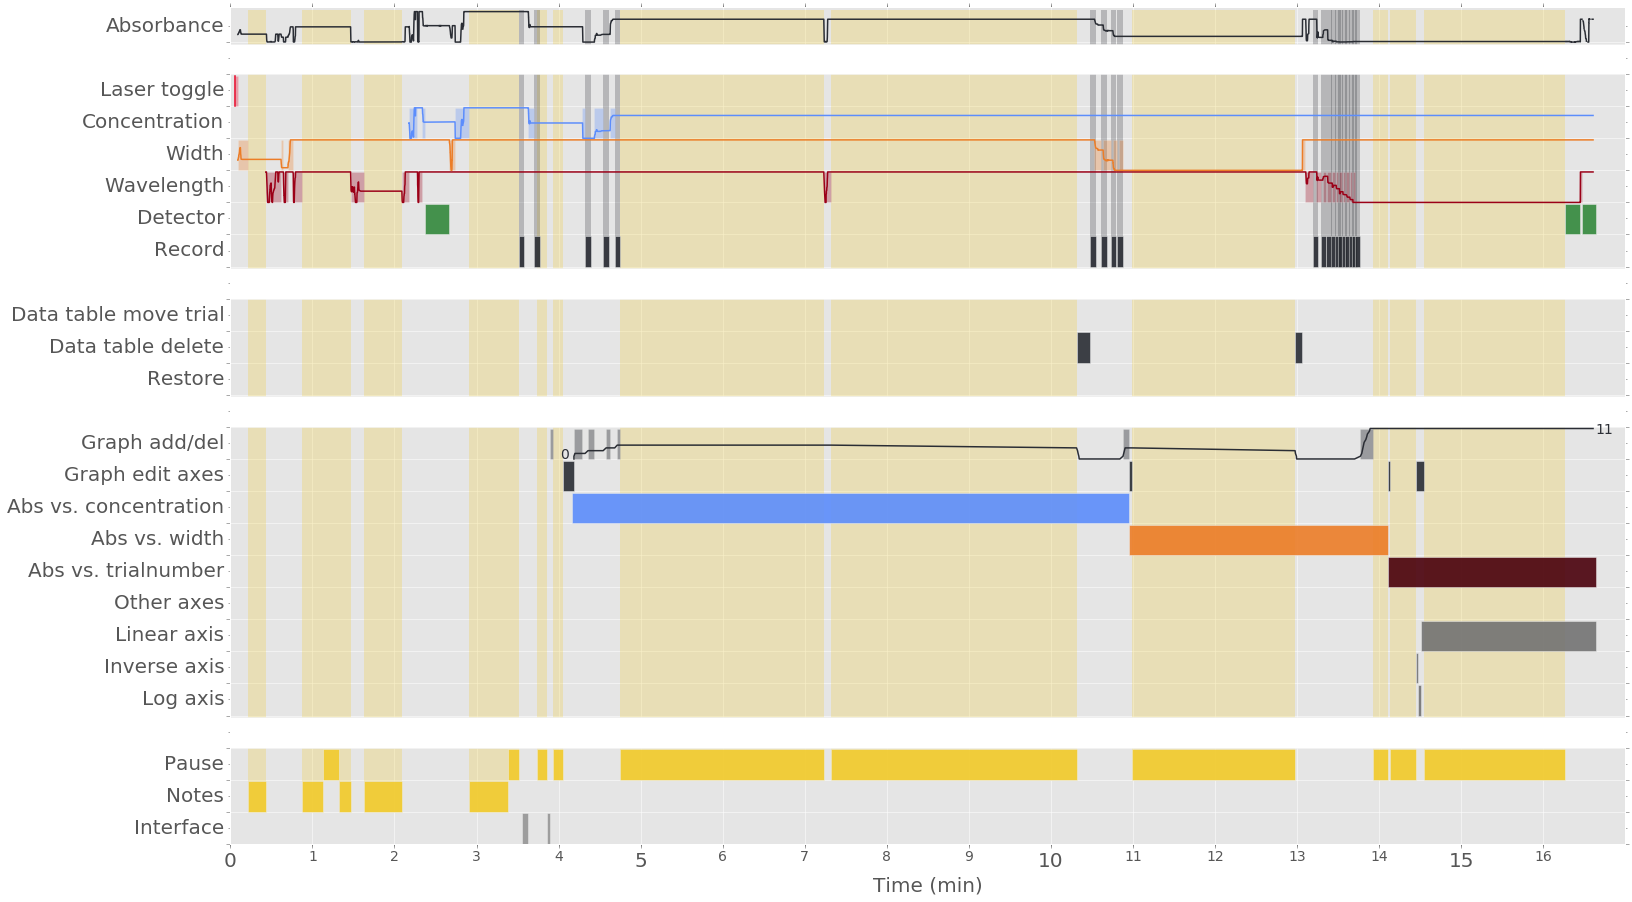

In [8]:
plot(df,to_plot_beers,family_name_to_code,function_to_use,colors)

In [9]:
#remove 'dragging' events, well still the drag_start and dragend
df = df[df['Event']!='dragged']
%time df['Sequence Action'] = df.apply(converter, axis=1)

Wall time: 392 ms


In [10]:
from itertools import groupby
sequence = [x[0] for x in groupby(df['Sequence Action'])]
# sequence

# Parsing beers for all students

In [11]:
df_all = get_df_all_factors()

In [12]:
ids = list(set(df_all['sid']))
N = len(ids)
print N

147


## Parsing

In [20]:
%%time
all_beers_seqs = {}
all_beers_blocked_seqs = {}
for student in ids:
    files = log_files_per_sim['beers'][student]
    files.sort()
    seq = []
    for f in files:
        df = prep_parsing_data(f) #removes model events, adds pauses with arbitrary threshold of 9s
        df = df[df['Event']!='dragged'] #remove drag events, keep dragStart and dragEnded
        if df.empty:
            continue
        else:
            df['Sequence Action'] = df.apply(converter, axis=1)
            if df[df['Sequence Action']=='no_match_found'].empty:
                pass
            else:
                print student
                print df[df['Sequence Action']=='no_match_found']
                raise ValueError("some events were not parsed")
        seq.extend(list(df['Sequence Action']))
    all_beers_seqs[student] = seq
    all_beers_blocked_seqs[student] = [x[0] for x in groupby(seq)]

Wall time: 2min 52s


In [21]:
import pickle
pickle_out_seqs = open(os.path.join(BIG_FOLDER,'all_massaged_data\\dict_by_student_beers_parsed_seqs.txt'),"wb")
pickle_out_blocked_seqs = open(os.path.join(BIG_FOLDER,'all_massaged_data\\dict_by_student_beers_parsed_blocked_seqs.txt'),"wb")
pickle.dump(all_beers_seqs, pickle_out_seqs)
pickle.dump(all_beers_blocked_seqs, pickle_out_blocked_seqs)
pickle_out_seqs.close()
pickle_out_blocked_seqs.close()

# Load pickled file

In [22]:
import pickle
pickle_in_seqs = open(os.path.join(BIG_FOLDER,'all_massaged_data\\dict_by_student_beers_parsed_seqs.txt'),"r")
pickle_in_blocked_seqs = open(os.path.join(BIG_FOLDER,'all_massaged_data\\dict_by_student_beers_parsed_blocked_seqs.txt'),"r")
all_beers_seqs = pickle.load(pickle_in_seqs)
all_beers_blocked_seqs = pickle.load(pickle_in_blocked_seqs)
pickle_in_seqs.close()
pickle_in_blocked_seqs.close()

# Descriptives of blocked seqs

In [32]:
nb_use = {}
axis_vars = ['concentration','outcome','width','trialnumber']
axis_scales = ['log','linear','inverse']
actions = ['pause','graph_add_first','graph_add_cvs',
           'graph_add_messy','table_remove','graph_remove',
           'table_add_first',"table_add_cvs","table_add_messy"]
actions.extend(['graph_axis_'+v for v in axis_vars])
actions.extend(['graph_scale_'+v for v in axis_scales])

for a in actions:
    nb_use[a] = []
    for student, seq in all_beers_blocked_seqs.iteritems():
        nb_use[a].append(seq.count(a))
actions.sort()

graph_add_cvs
graph_add_first
graph_add_messy
graph_axis_concentration
graph_axis_outcome
graph_axis_trialnumber
graph_axis_width
graph_remove
graph_scale_inverse
graph_scale_linear
graph_scale_log
pause
table_add_cvs
table_add_first
table_add_messy
table_remove


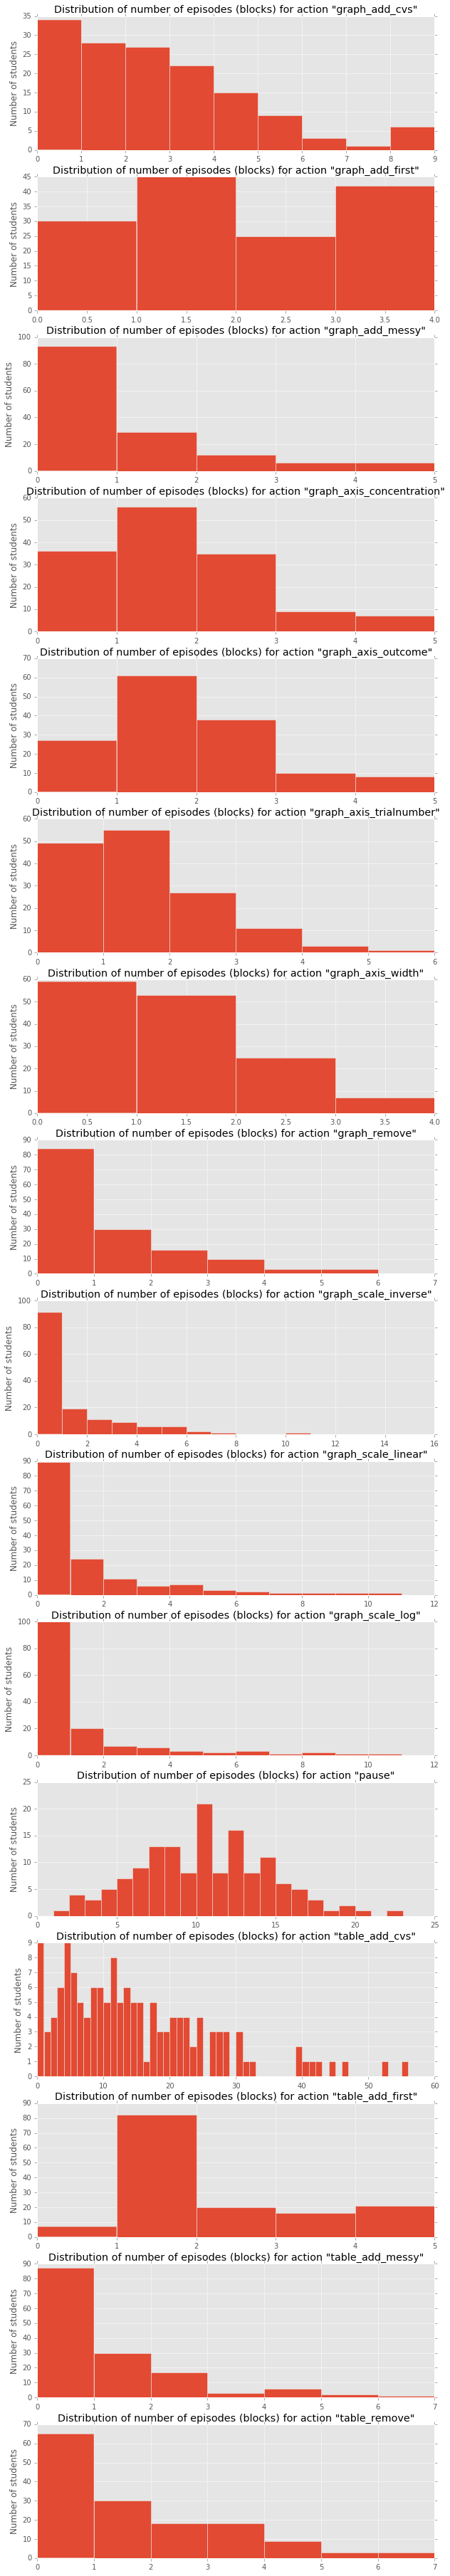

In [33]:
fig,axes = plt.subplots(nrows=len(actions),ncols=1,figsize=(10,4*len(actions)))
for i,a in enumerate(actions):
    print a
    ax=axes[i]
    ax.hist(nb_use[a],bins=range(max(nb_use[a])))
    ax.set(title='Distribution of number of episodes (blocks) for action "{0}"'.format(a))
    ax.set(ylabel='Number of students')

# to do
* write rules for caps
* unblock certain actions?

# Old code keeping for now

Consecutive table_add_cvs

In [ ]:
# regex_pattern_trial = re.compile('trialNumber (\d+)')
# def check_cvs_table(row):
#     if row['Sequence Action']=='table_add':
#         trial_number = int(regex_pattern_trial.match(row['Item']).group(1))
#         table = json.loads(row['Table'])

#         # if it's the first trial added or the table only has one trial, no possibility for doing cvs
#         if trial_number == 1 or len(table)==1:
#             return "table_add_first"
#         else:
#             #the last trial added in table (that still is in table and wasn't deleted) will have the greatest trial number
#             last_trial_number = max([int(key) for key in table.keys() if int(key)!=trial_number])
#             current_trial = table[str(trial_number)]
#             last_trial = table[str(last_trial_number)]
#     #         print trial_number, last_trial_number
#             #we make sets of the all the values of variables between both trials
#             values_of_2_points = get_values_per_variable([current_trial, last_trial])
#     #         print values_of_2_points
#             confounded = pts_are_confounded(values_of_2_points)
#             outcomes = get_outcome_values([current_trial, last_trial])
#             outcome1,outcome2 = outcomes[0],outcomes[1]
#             #we check that only one variable is changed (confounded = False)
#             # that the laser was not off, and that the connection wasn't to lightbulb
#             # and that the outcome values are not null but floats
#             if not confounded and 0 not in values_of_2_points["Laser toggle"] and "LIGHT_BULB_CONNECTED" not in values_of_2_points["Connection"] and isinstance(outcome1, float) and isinstance(outcome2, float):
#                 return "table_add_cvs"
#             else:
#                 return "table_add_messy"
#     else: return row['Sequence Action']

# # row= df.iloc[2387]
# # # row = df.iloc[2438]
# # check_cvs_table(row)

In [ ]:
# students = [19989152,10537160,13654167,11929166]
# for s in students:
#     print '\n\n\n\n'
#     print s
#     print '\n\n'
#     print [x[0] for x in groupby(all_beers_logs[s])]